In [6]:
'''
1. Fresh run on all genomes with the lastest GeneMark-ES
2. Parse GeneMark-ES output model file in the last run and plot exon/spacer/intron length distribution 
3. find connect between exon density and the exon/spacer/intron distribution
Build class ESModel, to extract information(spacer, exon, intron length distribution)
Parameters:

$SINGLE_DISTR
$INITIAL_DISTR
$EXON_DISTR
$TERMINAL_DISTR
$INTRON_DISTR
'''
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
% matplotlib inline
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150829.csv")
fulldata.index = fulldata['shortName']

# The path where all the GeneMark-ES 4th run models located
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/" 

In [7]:
## Build class ESModel, to extract information(spacer, exon, intron length distribution)
## functions of max positon are similar but it's convenient to not consolidate as a single one
class ESModel():
    """Take in 4th run of model file as text and extract info"""
    def __init__(self, filename):
        self.f = open(filename)
    
    def maxSpacerPosition(self):
        '''
        return the position with the highest probability
        '''
        spacerData = []
        switch = False
        for line in self.f:
            if switch:
                spacerData.append(line)
            if "$BP_ACC_DISTR" in line:
                switch = True
            if "40\t" in line:
                switch = False
                break

        spacerData = map(lambda line: line.rstrip().split("\t"), spacerData)
        spacerDistr = map(lambda (a,b): float(b), spacerData)
        positionProb = np.array(spacerDistr)
        # print positionProb
        return range(2,41)[positionProb.argmax()]
    
    def maxExonPosition(self, length = 9999):
        '''
        return the position with the highest probability
        '''
        exonData = []
        switch = False
        for line in self.f:
            if switch:
                exonData.append(line)
            if "$EXON_DISTR" in line:
                switch = True
            if switch and "{}\t".format(length) in line:
                switch = False
                break

        exonData = map(lambda line: line.rstrip().split("\t"), exonData)
        exonDistr = map(lambda (a,b): float(b), exonData)
        positionProb = np.array(exonDistr)
        # print positionProb
        try:
            return range(3,10000)[positionProb.argmax()]
        except:
            return 'NA'

    def maxIntronPosition(self, length = 3000):
            '''
            return the position with the highest probability
            '''
            intronData = []
            switch = False
            for line in self.f:
                if switch:
                    intronData.append(line)
                if "$INTRON_DISTR" in line:
                    switch = True
                if switch and "{}\t".format(length) in line:
                    switch = False
                    break

            intronData = map(lambda line: line.rstrip().split("\t"), intronData)
            intronDistr = map(lambda (a,b): float(b), intronData)
            positionProb = np.array(intronDistr)
            # print positionProb
            try:
                return range(20,3000)[positionProb.argmax()]
            except:
                return 'NA'

    def maxDonorToBpIntronPosition(self, length = 3000):
            '''
            return the position with the highest probability
            '''
            intronData = []
            switch = False
            for line in self.f:
                if switch:
                    intronData.append(line)
                if "$DON_BP_DISTR" in line:
                    switch = True
                if switch and "{}\t".format(length) in line:
                    switch = False
                    break

            intronData = map(lambda line: line.rstrip().split("\t"), intronData)
            intronDistr = map(lambda (a,b): float(b), intronData)
            positionProb = np.array(intronDistr)
            # print positionProb
            try:
                return range(20,3000)[positionProb.argmax()]
            except:
                return 'NA'
    def close(self):
        self.f.close()

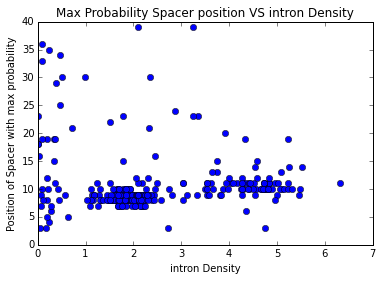

In [31]:
## generate plot of spacer length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
for shortName in fulldata.index:
    if fulldata.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = fulldata.loc[shortName,'intronDensityGff3']
        intronDensity2 = fulldata.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityExonDistrPair.append((shortName,intronDensity,model.maxSpacerPosition())) 
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)
plt.plot(data[:,1], data[:,2], "o")
plt.xlabel("intron Density")
plt.ylabel("Position of Spacer with max probability")
plt.title("Max Probability Spacer position VS intron Density")

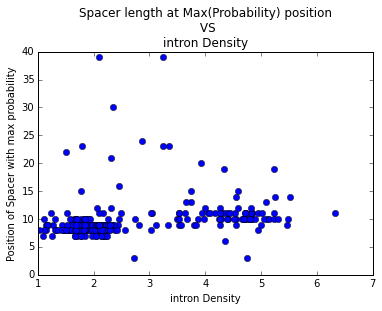

In [32]:
## get rid of the part with intron density < 1

## generate plot of spacer length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"

f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]


for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        # need to pair this with gc
        intronDensityExonDistrPair.append((shortName,filteredData.loc[shortName,'gc'],
                                           intronDensity,model.maxSpacerPosition())) 
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)
plt.plot(data[:,2], data[:,3], "o")
plt.xlabel("intron Density")
plt.ylabel("Position of Spacer with max probability")
# plt.title("Spacer position at Max(Probability) VS intron Density")
plt.title("Spacer length at Max(Probability) position \n VS \nintron Density")

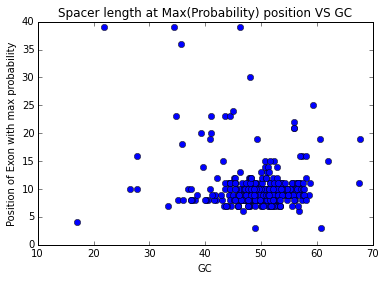

In [34]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "o")
plt.xlabel("GC")
plt.ylabel("Position of Exon with max probability")
# plt.title("Exon position at max(Probability) VS Intron Density")
plt.title("Spacer length at Max(Probability) position VS GC")

In [35]:
## generate plot of exon length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityExonDistrPair = []
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityExonDistrPair.append((shortName,filteredData.loc[shortName,'gc'],
                                           intronDensity,model.maxExonPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityExonDistrPair)

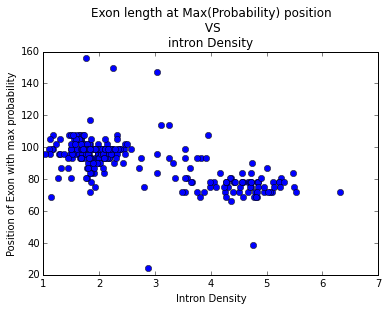

In [36]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "o")
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
# plt.title("Exon position at Max(Probability) VS Intron Density")
plt.title("Exon length at Max(Probability) position \n VS \nintron Density")

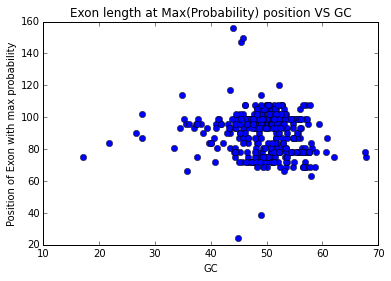

In [37]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "o")
plt.xlabel("GC")
plt.ylabel("Position of Exon with max probability")
# plt.title("Exon position at max(Probability) VS Intron Density")
plt.title("Exon length at Max(Probability) position VS GC")

In [38]:
## generate plot of intron length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityIntronDistrPair = []
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        intronDensityIntronDistrPair.append((shortName,filteredData.loc[shortName,'gc'],
                                             intronDensity,model.maxIntronPosition())) # need to pair this with gc
        model.close()
#         print filepath
data = np.array(intronDensityIntronDistrPair)

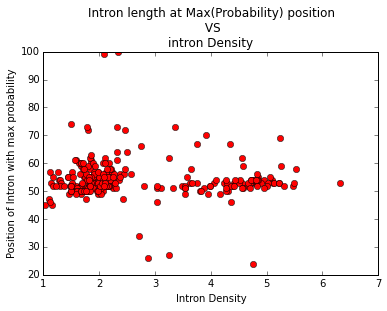

In [39]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "or")
plt.xlabel("Intron Density")
plt.ylabel("Position of Intron with max probability")
# plt.title("Intron position at Max(Probability) VS Intron Density")
plt.title("Intron length at Max(Probability) position \n VS \nintron Density")

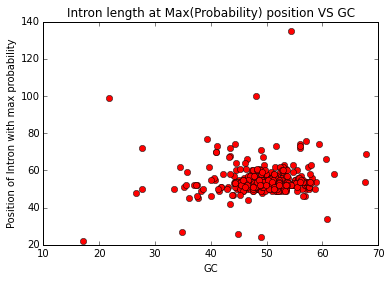

In [40]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "or")
plt.xlabel("GC")
plt.ylabel("Position of Intron with max probability")
# plt.title("Intron position at Max(Probability) VS GC")
plt.title("Intron length at Max(Probability) position VS GC")

In [20]:
## generate plot of donor to BP intron length distribution and figure out the relation between intron density
## find the intron density VS max position
intronDensityIntronDistrPair = []
f1 = fulldata['intronDensityGff3'] > 1
f2 = fulldata['intronDensityGff'] > 1
filteredData = fulldata[f1|f2]
for shortName in filteredData.index:
    if filteredData.loc[shortName,'ES'] == 'pass':
        filepath = "{}{}{}".format(modelFilePath, shortName,".ES_C_4.mod")
        model = ESModel(filepath)
        ## make a list of 3-tuple, shortName, gc, maxSpacerPosition
        intronDensity1 = filteredData.loc[shortName,'intronDensityGff3']
        intronDensity2 = filteredData.loc[shortName,'intronDensityGff']
        intronDensity = intronDensity1 if pd.isnull(intronDensity1) else intronDensity2
        # need to pair this with gc
        intronDensityIntronDistrPair.append((shortName,filteredData.loc[shortName,'gc'],
                                             intronDensity,model.maxDonorToBpIntronPosition())) 
        model.close()
#         print filepath
data = np.array(intronDensityIntronDistrPair)

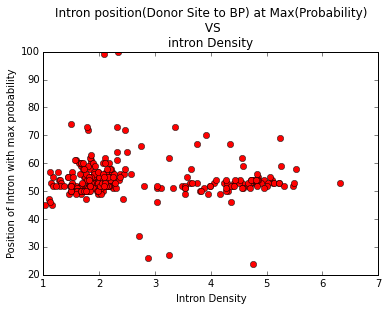

In [41]:
# plotting continue from last part, X = intron density
plt.plot(data[:,2], data[:,3], "or")
plt.xlabel("Intron Density")
plt.ylabel("Position of Intron with max probability")
# plt.title("Intron position(Donor Site to BP) at Max(Probability) VS Intron Density")
plt.title("Intron position(Donor Site to BP) at Max(Probability) \n VS \nintron Density")

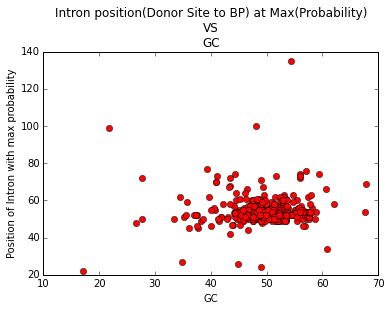

In [44]:
# plotting continue from last part, X = GC
plt.plot(data[:,1], data[:,3], "or")
plt.xlabel("GC")
plt.ylabel("Position of Intron with max probability")
plt.title("Intron position(Donor Site to BP) at Max(Probability) \nVS\nGC")